# But what *is* Optimal Transport?

Logistics. It's a very old problem - something is here and it needs to go there. For example, here is a pile of dirt that needs to be moved into the pit:

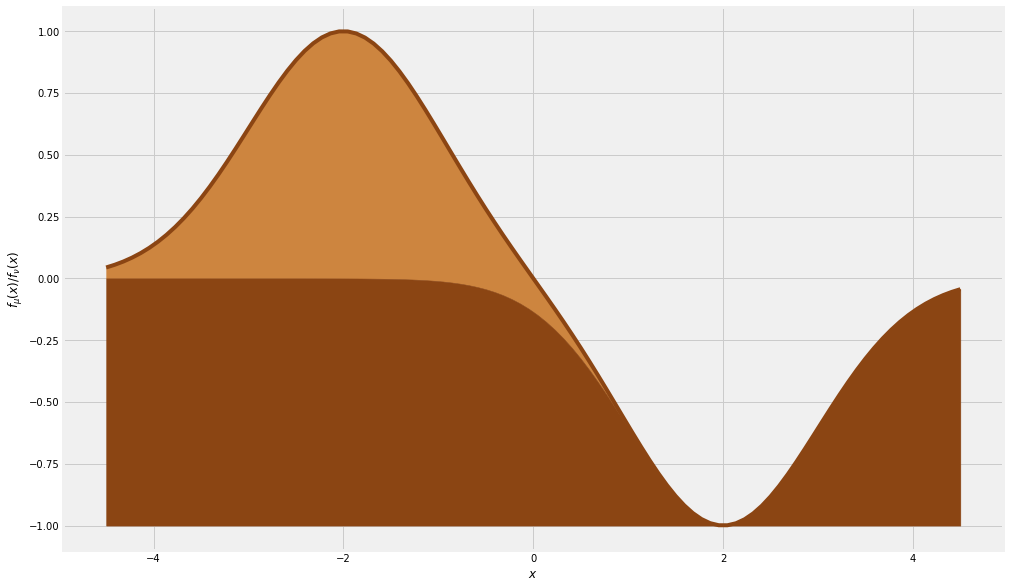

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# The dirt happens to be a normal distribution
def normal(x, var, mean):
          return np.exp(-(x-mean)**2/(2*var))

fig, ax = plt.subplots(figsize=(15,10))

xs = np.linspace(-4.5, 4.5, 100)
dirt = normal(xs, 1, -2)
pit = -normal(xs, 1, 2)

ax.plot(xs, dirt + pit, color='saddlebrown')
plt.fill_between(xs, pit, dirt + pit, color='peru')
ax.fill_between(xs,-1, pit, color='saddlebrown')

plt.xlabel('$x$')
plt.ylabel('$f_\mu(x) / f_\\nu(x)$')
plt.show()

## Transport Plans

Optimal Transport answeres this type of question by devising a transport plan. The inital configuration and the desired configuration are understood as two measures $\mu$ and $\nu$. For example here, $\mu_{\text{Dirt}}(A)$, defined on the Borel $\sigma$-algebra on $\mathbb R$, measures the amount of dirt on some piece of the ground $A \subset \mathbb R$. $\nu_{\text{Hole}}$ measures the amount of dirt needed to fill the pit.

However, moving dirt from $x$ to $y$ is laborious, so we apply a cost function. Sensible would be this one here, where the effort is proportional to the transported distance in space: $c(x,y) = |x - y|$.

What Optimal Transport finds is a map 

$$T: \mathbb R \to \mathbb R$$

, so that the pile lands where it needs to and the effort $\int c(x, T(x)) \mu(x) \text d x$ is minimal. That is then called the optimal transport map.

We can then concieve of a transport plan describing the map. This will be a measure on the product space

$$\gamma: \mathcal B (\mathbb R^2) \to \mathbb R$$

where the value $\gamma(A \times B)$ for $A, B \subset \mathbb R$ is the amount of mass moved from $A$ to $B$. The density function of these give a pretty - and pretty instructive - picture, so let's compute our first transport plan with the example above. This is the optimal one:

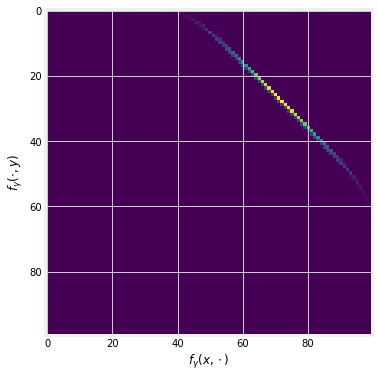

In [2]:
import scipy.io

def NWC(mu,nu):
    """
    This function computes the optimal transport plan.
    
    Input: mu, a vector respresenting a point measure of the origin distribution
           nu, a vector respresenting a point measure of the target distribution
    
    Output: gamma, a matrix representing a joint distribution
    
    """
    M=mu.shape[0]
    N=nu.shape[0]
    gamma=np.zeros((M,N))
    sumr=np.zeros(M)
    sumc=np.zeros(N)
    i=j=0
    while (i<M) and (j<N):
        delta=min(mu[i]-sumr[i],nu[j]-sumc[j])
        gamma[i,j]+=delta
        sumr[i]+=delta
        sumc[j]+=delta
        if mu[i]-sumr[i]<=1E-15:
            i+=1
        elif nu[j]-sumc[j]<=1E-15:
            j+=1
    return gamma

transport_plan = NWC(dirt / sum(dirt), pit / sum(pit))

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(transport_plan)
ax.set_xlabel('$f_\gamma({x, \\cdot})$')
ax.set_ylabel('$f_\gamma({\cdot, y})$')
plt.show()

So how should we read this? Each row at height $y$ is the distribution of where the infinitesimal pinch of dirt goes in the end. Here, this distribution is discrete; every infinitesimal piece is uniquely mapped to another. So here, because the line is also straight, it just means that every infinitesimal pinch is shifted over by the distance of the mean of both distribution.

To check your understanding, you can think about what the less often considered column distributions mean here.

To see that the sums indeed make a distribution, let's plot them again in a way that makes clear why the sums are called marginal distributions:

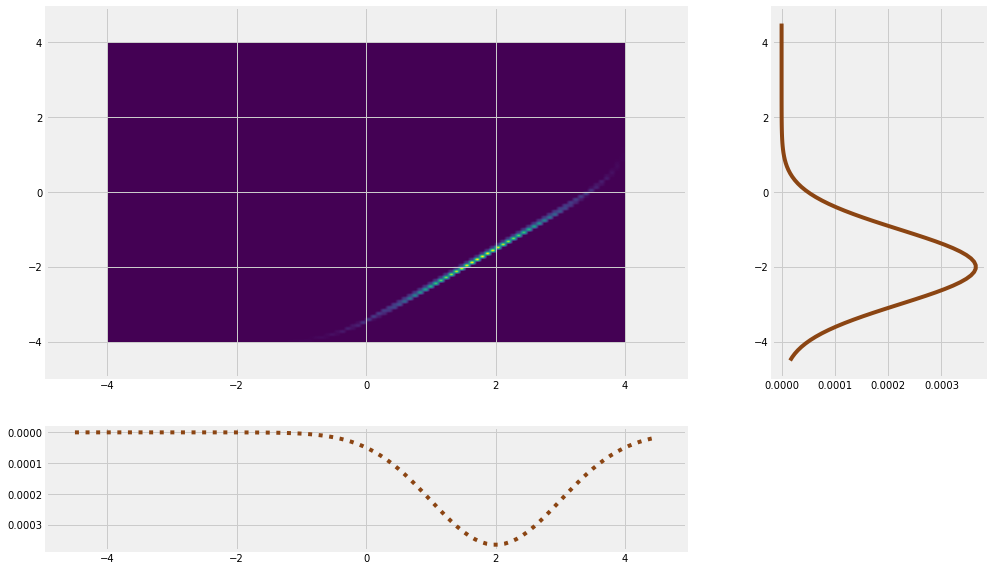

In [3]:
from matplotlib import gridspec as grid

plt.figure(figsize=(15,10))
gs = grid.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1])
ax = plt.subplot(gs[0,0])
axl = plt.subplot(gs[0,1], sharey=ax)
ax2 = plt.subplot(gs[1,0], sharex=ax)

ax.imshow(transport_plan, origin='lower', extent=[-4, 4, -4, 4], aspect='auto')
axl.plot(transport_plan.mean(1), xs, color='saddlebrown')
ax2.plot(xs, transport_plan.mean(0), ls = 'dotted', color='saddlebrown')
ax2.invert_yaxis()

plt.show()

However, any picture where the margins sum up to $\mu$ and $\nu$, as in this plot here, is a valid transport map between the dirt and the pit.

### Interactive Transport
Let's see this optimal transport plan in action by linearly interpolating the course of the dirt during the process. The slider represents a sort of time elapsed:

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Checkbox, widgets
from IPython.display import display

def plot_density(t):
    plt.figure(figsize=(15,10))
    plt.ylim([-1.2, 1.2])
    
    dirt = normal(xs, 1, -2 + 4 * t)
    pit = - normal(xs, 1, 2)
    
    plt.plot(xs, dirt + pit, color='saddlebrown')
    plt.fill_between(xs, pit, dirt + pit, color='peru')
    plt.fill_between(xs,-1.2, pit, color='saddlebrown')
    
    plt.show()

# Creating widgets for interactive visualization
t_widget = FloatSlider(description='Time $t$', 
                     min=0, max=1, step=0.01)

ui = widgets.VBox([t_widget])
widget = interactive(plot_density, t=0)
out = widgets.interactive_output(plot_density, {'t': t_widget})

display(ui, out)

Output()

We can equivalently - and perhaps more instructively - look at the pit as a second hill to be mapped to. We draw a dotted line outlining its shape above the x-axis:

In [16]:
def plot_density(t):
    plt.figure(figsize=(15,10))
    plt.ylim([-1.2, 1.2])
    
    dirt = normal(xs, 1, -2 + 4 * t)
    pit = - normal(xs, 1, 2)
    
    plt.plot(xs, dirt, color='saddlebrown')
    plt.plot(xs, -pit, linestyle="dashed", color='saddlebrown')
    plt.fill_between(xs, pit, dirt, color='peru')
    plt.fill_between(xs,-1.2, 0, color='saddlebrown')
    
    plt.show()

widget = interactive(plot_density, t=0)
out = widgets.interactive_output(plot_density, {'t': t_widget})

display(ui, out)

Output()

And since that was really fun, here is another example, where the original distribution is a gaussian with high variance and the target distribution is a gaussian with low variance. Gathering dust, so to speak. The optimal transport map is:

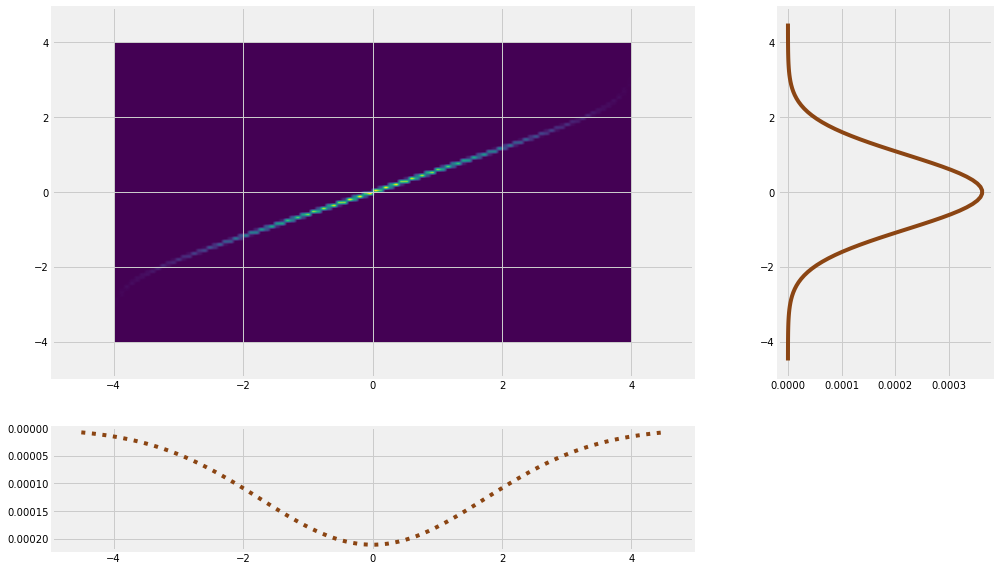

In [7]:
mu = normal(xs, 1, 0)
nu = -normal(xs, 3, 0)

# Calculating the optimal transport plan:
transport_plan = NWC(mu / sum(mu), nu / sum(nu))

plt.figure(figsize=(15,10))
gs = grid.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1])
ax = plt.subplot(gs[0,0])
axl = plt.subplot(gs[0,1], sharey=ax)
ax2 = plt.subplot(gs[1,0], sharex=ax)

ax.imshow(transport_plan, origin='lower', extent=[-4, 4, -4, 4], aspect='auto')
axl.plot(transport_plan.mean(1), xs, color='saddlebrown')
ax2.plot(xs, transport_plan.mean(0), ls = 'dotted', color='saddlebrown')
ax2.invert_yaxis()

plt.show()

As we can see from the now slanted line, each infinitesimal piece is mapped to one that is a little more on the tail of the distribution. In action, this looks like this:

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Checkbox, widgets
from IPython.display import display

def plot_density(t):
    plt.figure(figsize=(14,8))
    plt.ylim([-0.06, 0.02])
    
    xs = np.linspace(-6, 6, 100)
    
    dirt = normal(xs, 4 - 3 * (t/100), 0)
    dirt /= sum(dirt)
    pit = normal(xs, 1, 0)
    pit /= - sum(pit)
    
    plt.plot(xs, dirt + pit, color='saddlebrown')
    plt.fill_between(xs, pit, dirt + pit, color='peru')
    plt.fill_between(xs,-1.2, pit, color='saddlebrown')

widgets.interact(plot_density, t=widgets.Play(min=0, max=100))

interactive(children=(Play(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_density(t)>

## Optimal Transport's Bread and Butter

So far we have considered (approximations to) continuous measures on the real line. However, optimal transport can happen on any measure space. Another famous problem considers the city of Paris $\Omega \in \mathbb R^2$ as the state space, and we have two point measures $\mu, \nu$ describing cafés and bakeries serving and producing bread.

So how should we get the bread from the bakeries to the cafés, from $\mu$ to $\nu$. Well, we can formulate, as before, a transport plan $\gamma$. But because there are only finitely many cafés and bakeries though, we can think of it as a matrix - $\gamma_{i, j}$ specifies how much bread has to go from bakery $i$ to café $j$. This means we don't think of measures $\mathcal B (\mathbb R^2) \to \mathbb R$ this time, but simply vectors denoting the production and consumption of each as $\mu$ and $\nu$.

To encode the cost, we have another matrix, the cost matrix, where the entries $c_{i, j}$ describe how difficult it is to transport the baked goods from $i$ to $j$. Then we need to minimize

$$\langle c, \gamma \rangle = \sum_i\sum_j c_{i,j} \cdot \gamma_{i,j}$$

In [9]:
import assets.ot as ot

M = 10
N = 10
r = np.random.random(M)
s = np.random.random(N)
r = r/np.sum(r)
s = s/np.sum(s)
X = np.array([np.random.random(M)-2,np.random.random(M)]).T
Y = np.array([np.random.random(N)+1,np.random.random(N)]).T

(valXY,gamma) = ot.solveOT(X,r,Y,s)

def plot_transport(t):
    fig = plt.figure(figsize=(12,8))
    ax=plt.gca()
    
    
    ax.scatter(X[:,0],X[:,1],s=r*1000,c="orchid",label='Bakeries')
    ax.scatter(Y[:,0],Y[:,1],s=s*1000,c="orange",label='Cafés')
    ax.legend()
    
    lineCollection = ot.getCouplingLines(gamma,X,Y,thresh=1E-5,lwscale=1.,\
                                    color="grey",ls="dashed",zorder=-1)
    ax.add_collection(lineCollection)

    Z = []
    m = []
    for i in range(M):
            for j in range(N):
                if gamma[i,j] > 0:
                    Z.append((1-(t/100))*X[i]+(t/100)*Y[j])
                    m.append(gamma[i,j])

    Z = np.array(Z)
    m = np.array(m)

    ax.scatter(Z[:,0],Z[:,1],s=m*1000,c="lightpink")

widgets.interact(plot_transport, t=widgets.Play(min=0, max=100))

interactive(children=(Play(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_transport(t)>

### Transport Plans vs Transport Maps

Depending on the example you rolled in the above widget, you can observe a crucial difference in this problem over the last one: The bread from one bakery might end up at multiple cafés. This makes it impossible to obtain a well-defined transport map, which is highly relevant in applications. In any case, the transport plan $\gamma$ that governs this is the more general concept.

## Historical Background and Conclusion

The first problem we looked at here is based on a thought experiment by 18th century mathematician, engineer and politician [Gaspard Monge](https://en.wikipedia.org/wiki/Gaspard_Monge). Optimal Transport in today's formulation is considerably younger however, dating back to the early 20th century. Here, the big name is [Leonid Kantorovich](https://en.wikipedia.org/wiki/Leonid_Kantorovich), a mathematician who was responsible for theoretical foundations behind central industrial planning in the Soviet Union. The bakery problem was one of his toy examples, which is why it is also known as the Kantorovich problem.

Today, optimal transport is used to solve all sorts of difficult problems. If you want to learn more, you can read through [this](Optimal_Transport_and_X-ray_Tomography.ipynb) notebook about how to understand Alzheimer's desease better using optimal transport. There is also [this](Colocalization_with_Optimal_Transport.ipynb) notebook about discovering chemical bonds between several types of molecules with optimal transport.

****

_Written by Fabian Fieberg and Lennart Finke. Published under the [MIT](https://mit-license.org/) license._